# Generating names with recurrent neural networks


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import keras
from keras import backend as K

# Load data
The dataset contains names of babies born in US along with their year of birth , state and gender . Although we will extract only names from this dataset

Data source : https://www.kaggle.com/kaggle/us-baby-names#NationalNames.csv

In [0]:
data=pd.read_csv("NationalNames.csv")

In [0]:
names=list(data['Name'].astype(str) )

In [0]:
pad_token='#'
start_token=' '

In [0]:
names = [start_token + name for name in names]

In [194]:
len(names)

269893

max length: 14


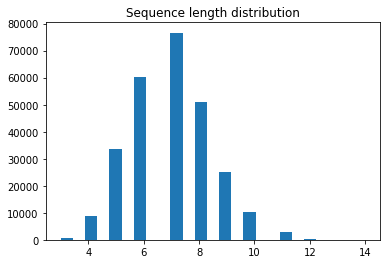

In [166]:
MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=25);

In [167]:
len(names)

269893

# Text processing

First we need to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [168]:
tokens = set(''.join(names)) 
tokens.add(pad_token)
tokens = list(tokens)
n_tokens = len(tokens)
print(tokens)
print(n_tokens)

['c', 'K', 'M', 'f', 'Z', 'k', 'N', ' ', 't', 'w', 'T', 'B', 'q', 'y', 'C', 'i', 'P', 'O', 'x', 'U', '#', 'X', 'A', 'I', 'W', 'z', 'u', 'p', 'S', 'm', 'G', 'n', 'Y', 'l', 'r', 'e', 'Q', 'b', 'E', 's', 'j', 'd', 'h', 'a', 'V', 'L', 'R', 'J', 'v', 'o', 'D', 'H', 'F', 'g']
54


In [169]:
token_to_id = {s : i for i, s in enumerate(tokens)} ### YOUR CODE HERE: create a dictionary of {symbol -> its  index in tokens}

print(token_to_id)

{'c': 0, 'K': 1, 'M': 2, 'f': 3, 'Z': 4, 'k': 5, 'N': 6, ' ': 7, 't': 8, 'w': 9, 'T': 10, 'B': 11, 'q': 12, 'y': 13, 'C': 14, 'i': 15, 'P': 16, 'O': 17, 'x': 18, 'U': 19, '#': 20, 'X': 21, 'A': 22, 'I': 23, 'W': 24, 'z': 25, 'u': 26, 'p': 27, 'S': 28, 'm': 29, 'G': 30, 'n': 31, 'Y': 32, 'l': 33, 'r': 34, 'e': 35, 'Q': 36, 'b': 37, 'E': 38, 's': 39, 'j': 40, 'd': 41, 'h': 42, 'a': 43, 'V': 44, 'L': 45, 'R': 46, 'J': 47, 'v': 48, 'o': 49, 'D': 50, 'H': 51, 'F': 52, 'g': 53}


In [0]:
def to_matrix(names, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
    """Casts a list of names into rnn-digestable padded matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad
    print(max_len)

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [0]:
s=reset_tf_session()

# Defining a recurrent neural network


In [0]:
import keras
from keras.layers import concatenate, Dense, Embedding

rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters



# an embedding layer that converts character ids into embeddings
embed_x = Embedding(n_tokens, embedding_size)

# a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
get_h_next = Dense(rnn_num_units, activation='tanh') 

# a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
get_probas = Dense(n_tokens, activation='softmax') 

We will generate names character by character starting with `start_token`:

<img src="./char-nn.png" width=600>

In [0]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces 
    probabilities for next token x_t+1 and next state h_t+1
    given current input x_t and previous state h_t.
    """
    # convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    
    # concatenate x_t embedding and previous h_t state
    x_and_h = concatenate([x_t_emb, h_t]) 
    
    # compute next state given x_and_h
    h_next = get_h_next(x_and_h)
    
    # get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next) 
    
    return output_probas, h_next

# RNN: loop


In [0]:
input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  # batch of token ids
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    

predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])


predicted_probas = predicted_probas[:, :-1, :]

In [177]:
predicted_probas.shape

TensorShape([Dimension(None), Dimension(13), Dimension(54)])

# RNN: loss and gradients



In [0]:
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])

answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

In [0]:

loss = -tf.reduce_mean(answers_matrix * tf.log(predictions_matrix))

optimize = tf.train.AdamOptimizer().minimize(loss)

Training

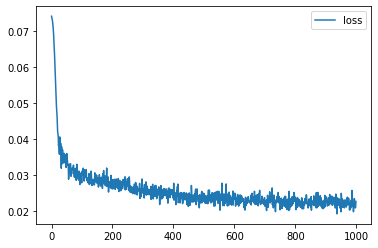

In [181]:
from IPython.display import clear_output
from random import sample

s.run(tf.global_variables_initializer())

batch_size = 32
history = []

for i in range(1000):
    batch = to_matrix(sample(names, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge"

In [0]:
start_token = ' '

# RNN: sampling
Generate some stuff

In [0]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  # we will update hidden state in this variable

.
next_probs, next_h = rnn_one_step(x_t, h_t)

In [0]:
def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    '''
    This function generates text given a `seed_phrase` as a seed.
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))
    
    
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))        
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])

In [190]:
# without prefix
for _ in range(10):
    print(generate_sample())

 Alla
 Langra
 Atle
 Mamirk
 Irnerwa
 Oretpern
 Erwe
 Jleve
 Meurla
 Lugon


In [192]:
# with prefix
for _ in range(10):
    print(generate_sample('Tom'))

Tomvilia
Tomordia
Tomance
Tomoa
Tomiha
Tomavia
Tomie
Tommon
Tometova
TomowE
